In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datafold import (
    EDMD,
    DMDStandard,
    GaussianKernel,
    TSCPolynomialFeatures,
    TSCRadialBasis,
)
from datafold.utils._systems import Hopf
from datafold.utils.general import generate_2d_regular_mesh

In [14]:
system = Hopf()

# set up training data by sampling original Hopf system
n_timesteps = 21
time_values = np.linspace(0, 0.4, n_timesteps)

X_ic = generate_2d_regular_mesh(
    low=(-2, -2),
    high=(2, 2),
    n_xvalues=8,
    n_yvalues=8,
    feature_names=system.feature_names_in_,
)
X_tsc = system.predict(X_ic, time_values=time_values)

print(f"time delta: {X_tsc.delta_time}")
print(f"nr. time series: {X_tsc.n_timeseries}")
print(f"nr. timesteps per time series: {X_tsc.n_timesteps}")
print(f"(n_samples, n_features): {X_tsc.shape}")
print(f"time interval {X_tsc.time_interval()}")
print(f"Same time values: {X_tsc.is_same_time_values()}")
print("")
print("Data snippet fo training data:")
X_tsc

time delta: 0.019999999999999962
nr. time series: 64
nr. timesteps per time series: 21
(n_samples, n_features): (1344, 2)
time interval (0.0, 0.4)
Same time values: True

Data snippet fo training data:


feature        x1        x2
ID time                    
0  0.00 -2.000000 -2.000000
   0.02 -1.735789 -1.806650
   0.04 -1.547156 -1.676108
   0.06 -1.401879 -1.581086
   0.08 -1.286003 -1.510061
...           ...       ...
63 0.32  0.612206  1.218410
   0.34  0.578201  1.210363
   0.36  0.545490  1.203096
   0.38  0.513883  1.196435
   0.40  0.483307  1.190350

[1344 rows x 2 columns]

In [15]:
X_tsc.initial_states()

/home/uppili11/.local/lib/python3.10/site-packages/datafold/pcfold/timeseries/collection.py:1636: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  return self.groupby(by=TSCDataFrame.tsc_id_idx_name, axis=0, level=0).head(


,feature,x1,x2
ID,time,,
0,0.0,-2.000000,-2.0
1,0.0,-1.428571,-2.0
2,0.0,-0.857143,-2.0
3,0.0,-0.285714,-2.0
4,0.0,0.285714,-2.0
...,...,...,...
59,0.0,-0.285714,2.0
60,0.0,0.285714,2.0
61,0.0,0.857143,2.0


In [16]:
# function to add a single arrow in the following time series plots
idx_arrow = np.array([time_values.shape[0] // 2 - 1, time_values.shape[0] // 2])

def include_arrow(ax, df):
    arrow = df.iloc[idx_arrow, :]
    ax.arrow(
        arrow.iloc[0, 0],
        arrow.iloc[0, 1],
        dx=arrow.iloc[1, 0] - arrow.iloc[0, 0],
        dy=arrow.iloc[1, 1] - arrow.iloc[0, 1],
        color="black",
        head_width=0.05,
    )

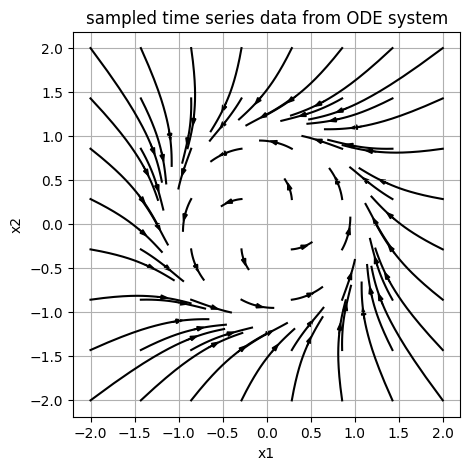

In [17]:
fig, ax = plt.subplots(figsize=[5, 5])

for _id, df in X_tsc.itertimeseries():
    ax.plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax, df)

ax.set_title("sampled time series data from ODE system")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.axis("equal")
ax.grid();

In [21]:
dmd = DMDStandard().fit(X=X_tsc, store_system_matrix=True)

# Check available attributes
attributes = [attr for attr in dir(dmd) if not callable(getattr(dmd, attr)) and not attr.startswith("__")]
print("Available Attributes:")
print(attributes)

# Print values of some common attributes
if 'dmd_modes' in attributes:
    print("DMD Modes:")
    print(dmd.dmd_modes)

if 'eigenvalues_' in attributes:
    print("Eigenvalues:")
    print(dmd.eigenvalues_)

Available Attributes:
['_abc_impl', '_cls_feature_attrs', '_cls_valid_sys_mode', '_cls_valid_sys_type', '_valid_reconstruct_modes', 'approx_generator', 'compute_pseudospectrum', 'control_matrix_', 'diagonalize', 'dmd_modes', 'dt_', 'eigenvalues_', 'eigenvectors_left_', 'eigenvectors_right_', 'feature_names_in_', 'is_control_affine', 'is_controlled', 'is_differential_system', 'is_flowmap_system', 'is_matrix_mode', 'is_spectral_mode', 'is_time_invariant', 'n_features_in_', 'rank', 'rcond', 'reconstruct_mode', 'residual_filter', 'sys_mode', 'sys_type', 'system_matrix_']
DMD Modes:
[[0.        +0.70710678j 0.        -0.70710678j]
 [0.70710678+0.j         0.70710678-0.j        ]]
Eigenvalues:
[0.97191225+0.01942801j 0.97191225-0.01942801j]


In [18]:
dmd = DMDStandard().fit(
    X=X_tsc, store_system_matrix=True
)  # X must be of type TSCDataFrame
dmd_values = dmd.predict(X_tsc.initial_states(), time_values=X_tsc.time_values())

# perform out-of-sample prediction (not contained in training data)
# note that the time sampling are independent of the original samples
dmd_values_oos = dmd.predict(np.array([-1.8, 2]), time_values=np.linspace(0, 100, 1000))

print(
    "Data snipped for predicted time series training data and out-of-sample prediction"
)
dmd_values

Data snipped for predicted time series training data and out-of-sample prediction


/home/uppili11/.local/lib/python3.10/site-packages/datafold/pcfold/timeseries/collection.py:1636: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  return self.groupby(by=TSCDataFrame.tsc_id_idx_name, axis=0, level=0).head(
/home/uppili11/.local/lib/python3.10/site-packages/datafold/pcfold/timeseries/collection.py:1666: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  return self.groupby(by=TSCDataFrame.tsc_id_idx_name, axis=0, level=0).tail(


feature        x1        x2
ID time                    
0  0.00 -2.000000 -2.000000
   0.02 -1.904968 -1.982681
   0.04 -1.812943 -1.964001
   0.06 -1.723865 -1.944059
   0.08 -1.637676 -1.922946
...           ...       ...
63 0.32  0.807571  1.607252
   0.34  0.753662  1.577797
   0.36  0.701840  1.548122
   0.38  0.652050  1.518274
   0.40  0.604238  1.488298

[1344 rows x 2 columns]

In [19]:
dmd_values_oos


feature                x1            x2
ID time                                
0  0.0000   -1.800000e+00  2.000000e+00
   0.1001   -1.727910e+00  1.571245e+00
   0.2002   -1.628486e+00  1.207205e+00
   0.3003   -1.511063e+00  9.014248e-01
   0.4004   -1.383147e+00  6.475208e-01
...                   ...           ...
   99.5996   4.590064e-62  1.696391e-61
   99.6997   2.493674e-62  1.504853e-61
   99.7998   8.491853e-63  1.321262e-61
   99.8999  -4.119139e-63  1.148451e-61
   100.0000 -1.351248e-62  9.882732e-62

[1000 rows x 2 columns]

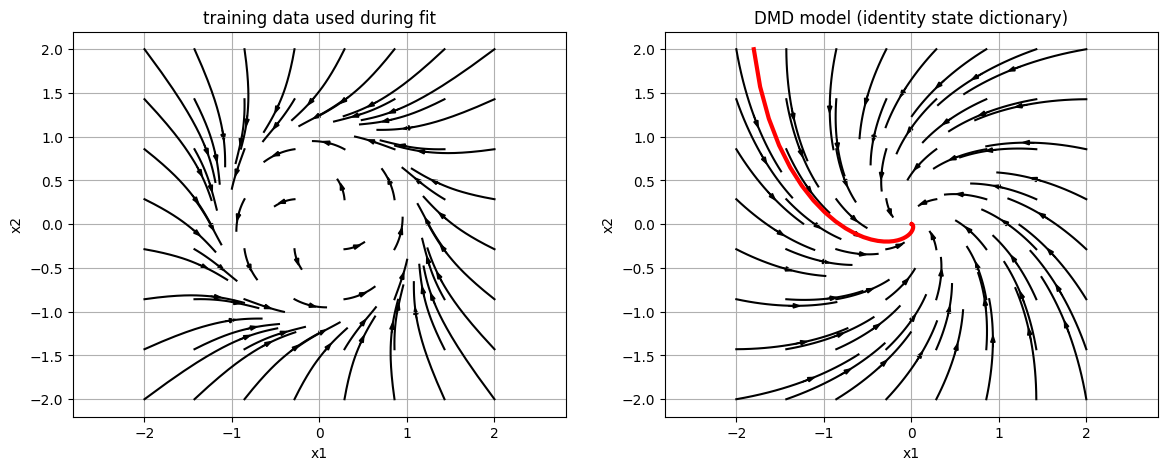

In [20]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
for _id, df in X_tsc.itertimeseries():
    ax[0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0], df)

ax[0].set_title("training data used during fit")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis("equal")
ax[0].grid()

for _id, df in dmd_values.itertimeseries():
    ax[1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[1], df)

ax[1].set_title("DMD model (identity state dictionary)")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].axis("equal")
ax[1].grid()


# generate red "out-of-sample" prediction, for extra analysis below
ax[1].plot(
    dmd_values_oos["x1"].to_numpy(),
    dmd_values_oos["x2"].to_numpy(),
    0.1,
    c="red",
    linewidth=3,
)
include_arrow(ax[1], dmd_values_oos)